Import needed packages:

In [1]:
import sys
sys.path.append('..')

from src.tp import StudentTProcess

In [2]:
import gpax
import numpy as np
import matplotlib.pyplot as plt

gpax.utils.enable_x64()  # enable double precision

## Create data

Generate some noisy observations:

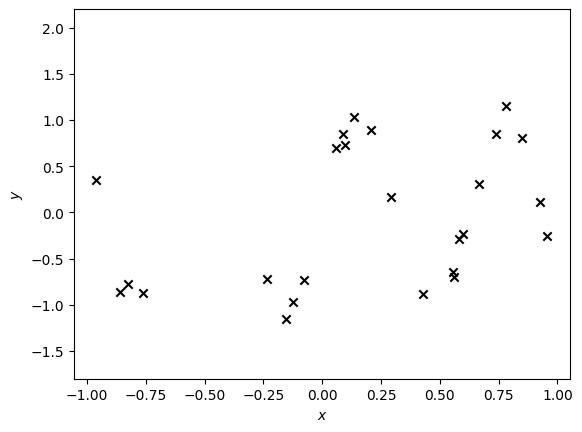

In [3]:
np.random.seed(0)

NUM_INIT_POINTS = 25 # number of observation points
NOISE_LEVEL = 0.1 # noise level

# Generate noisy data from a known function
f = lambda x: np.sin(10*x)

X = np.random.uniform(-1., 1., NUM_INIT_POINTS)
y = f(X) + np.random.normal(0., NOISE_LEVEL, NUM_INIT_POINTS)

# Plot generated data
plt.figure(dpi=100)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.scatter(X, y, marker='x', c='k', zorder=1, label='Noisy observations')
plt.ylim(-1.8, 2.2);

In [4]:
# Get random number generator keys for training and prediction
rng_key, rng_key_predict = gpax.utils.get_keys()

# Initialize model
tp_model = StudentTProcess(1, kernel='RBF')
# Run Hamiltonian Monte Carlo to obtain posterior samples for kernel parameters and model noise
tp_model.fit(rng_key, X, y, num_chains=1)

sample: 100%|██████████| 4000/4000 [00:04<00:00, 905.65it/s, 31 steps of size 1.59e-01. acc. prob=0.94] 


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         df      3.74      5.77      1.47      0.01     10.10    717.52      1.00
k_length[0]      0.15      0.03      0.15      0.10      0.20    911.98      1.00
    k_scale      3.90      3.90      2.73      0.36      8.01    823.60      1.00
      noise      0.11      0.11      0.08      0.01      0.24    743.08      1.00
          r      0.32      0.63      0.16      0.01      0.63    629.26      1.00



In [5]:
X_test = np.linspace(-1, 1, 100)
y_pred, y_sampled = tp_model.predict(rng_key_predict, X_test, n=200)

Plot the obtained results:

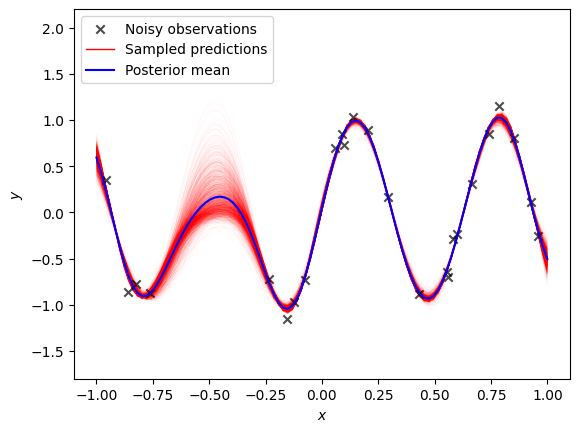

In [6]:
_, ax = plt.subplots(dpi=100)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.scatter(X, y, marker='x', c='k', zorder=1, label="Noisy observations", alpha=0.7)
for y1 in y_sampled:
    ax.plot(X_test, y1.mean(0), lw=.1, zorder=0, c='r', alpha=.1)
l, = ax.plot(X_test, y_sampled[0].mean(0), lw=1, c='r', alpha=1, label="Sampled predictions")
ax.plot(X_test, y_pred, lw=1.5, zorder=1, c='b', label='Posterior mean')
ax.legend(loc='upper left')
l.set_alpha(0)
ax.set_ylim(-1.8, 2.2);

In [10]:
print("axis=0")
print(f"shape: {y_sampled.std(axis=0).shape}")
print(y_sampled.std(axis=0))
print()
print("axis=1")
print(f"shape: {y_sampled.std(axis=1).shape}")
print(y_sampled.std(axis=1))
print()
print("axis=2")
print(f"shape: {y_sampled.std(axis=2).shape}")
print(y_sampled.std(axis=2))
print()
print("axis=-1")
print(f"shape: {y_sampled.std(axis=-1).shape}")
print(y_sampled.std(axis=-1))

axis=0
shape: (200, 100)
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]

axis=1
shape: (2000, 100)
[[0.34834636 0.2904974  0.27176568 ... 0.24046357 0.26752164 0.32128402]
 [0.25060043 0.24026271 0.20392985 ... 0.18074547 0.22879716 0.25927406]
 [0.23061929 0.1947162  0.15670578 ... 0.14148042 0.19142179 0.2095075 ]
 ...
 [0.24792913 0.21553752 0.1827326  ... 0.19677703 0.20968688 0.25166089]
 [0.26922231 0.21979799 0.20318285 ... 0.22241695 0.23108135 0.24830654]
 [0.24236606 0.1845702  0.16323043 ... 0.17415036 0.21063259 0.27541241]]

axis=2
shape: (2000, 200)
[[0.70011012 0.71103082 0.67250398 ... 0.68116337 0.77336399 0.67925968]
 [0.73195186 0.65641758 0.67918529 ... 0.67855457 0.8131646  0.64687081]
 [0.72768227 0.64824129 0.6811496  ... 0.66165612 0.64763201 0.66914042]
 ...
 [0.70049048 0.75525492 0.65664638 ... 0.66566667 0.67831698 

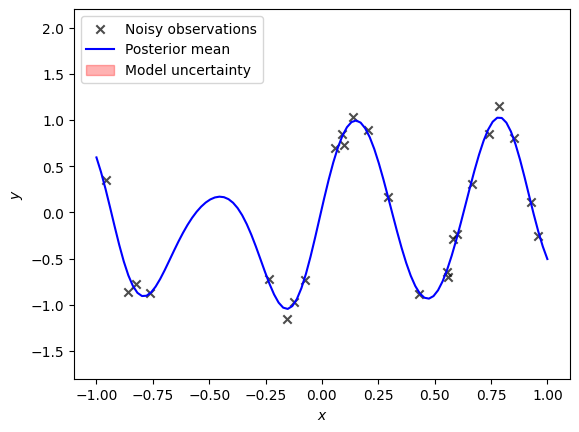

In [11]:
_, ax = plt.subplots(dpi=100)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.scatter(X, y, marker='x', c='k', zorder=2, label="Noisy observations", alpha=0.7)
ax.plot(X_test, y_pred, lw=1.5, zorder=2, c='b', label='Posterior mean')
ax.fill_between(X_test, y_pred - y_sampled.std(axis=(0,1)), y_pred + y_sampled.std(axis=(0,1)),
                color='r', alpha=0.3, label="Model uncertainty")
ax.legend(loc='upper left')
ax.set_ylim(-1.8, 2.2);

## Kernel with custom priors

Now let's do the same but with periodic kernel, $k_{periodic}=𝜎exp(-\frac{2sin^2(𝜋||x_i-x_j||/p)}{l^2})$. We can use the default one from GPax or we can specify custom priors for the periodic kernel parameters using NumPyro distributions. Let's do the latter. Generally, it is a good idea to visualize a distribution before using it as a prior. GPax has a convenient utility function for this:

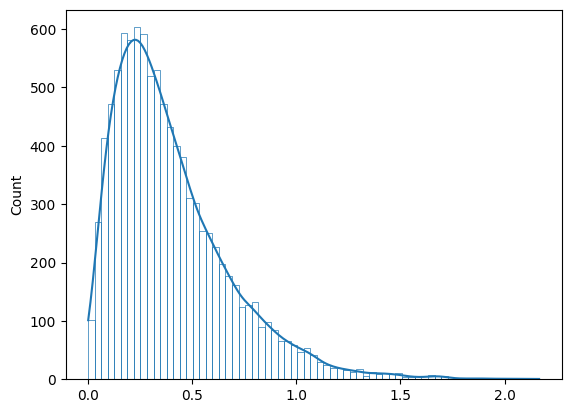

In [12]:
import numpyro

d = numpyro.distributions.Gamma(2, 5)

gpax.utils.dviz(d, samples=10000)

We are going to compare how a GP with periodic kernel behaves when we set a period to a constant value and when it is inferred from the data. For this, we define a function that returns a kernel prior for each value of period that we pass as an argument. When we pass a None value, the period is sampled from the prescribed prior distribution.

In [13]:
def get_kernel_prior(p=None):

    def kernel_prior():
        # Sample kernel length and output scales
        length = numpyro.sample("k_length", numpyro.distributions.Gamma(2, 5))
        scale = numpyro.sample("k_scale", numpyro.distributions.LogNormal(0, 1))
        # Sample period or set it to a constant value
        if p:
            period = numpyro.deterministic("period", p)
        else:
            period = numpyro.sample("period", numpyro.distributions.Gamma(2, 5))
        # Hyperparameters are returned as dictionary
        return {"k_length": length, "k_scale": scale, "period": period}
    
    return kernel_prior

Infer the GP kernel parameters using a custom kernel prior with the deterministic and probabilistic periods and make a prediction on test inputs:

/Users/keisukeonoue/ws/TPBO_jax/notebooks/../src/tp.py:97: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:04<00:00, 907.81it/s, 31 steps of size 1.22e-01. acc. prob=0.96] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        df      8.01      9.29      4.82      0.03     19.50    926.94      1.00
  k_length      0.32      0.28      0.23      0.01      0.71   1389.28      1.00
   k_scale      0.42      0.40      0.30      0.03      0.85   1304.00      1.00
     noise      1.37      1.37      1.01      0.24      2.65    892.42      1.00
    period      0.30      0.00      0.30      0.30      0.30      0.50      1.00
         r      0.23      0.39      0.11      0.01      0.49    634.38      1.00



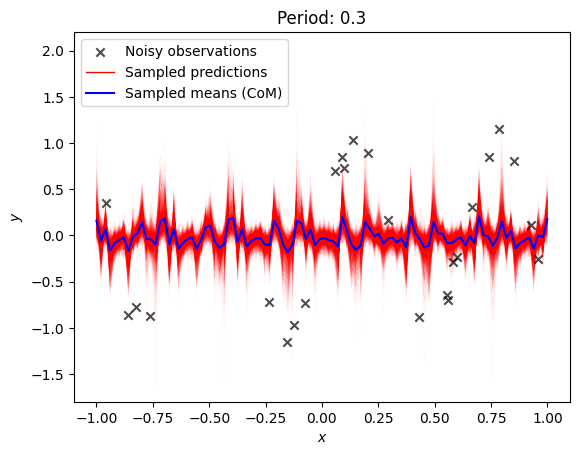

/Users/keisukeonoue/ws/TPBO_jax/notebooks/../src/tp.py:97: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:04<00:00, 952.81it/s, 31 steps of size 1.49e-01. acc. prob=0.94] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        df      4.93      6.57      2.39      0.01     13.06    695.77      1.00
  k_length      1.06      0.31      1.03      0.57      1.53   1139.27      1.00
   k_scale      1.74      1.60      1.26      0.22      3.53    826.58      1.00
     noise      0.24      0.22      0.17      0.03      0.48    794.08      1.00
    period      0.60      0.00      0.60      0.60      0.60      0.50      1.00
         r      0.31      0.89      0.14      0.02      0.58    711.13      1.00



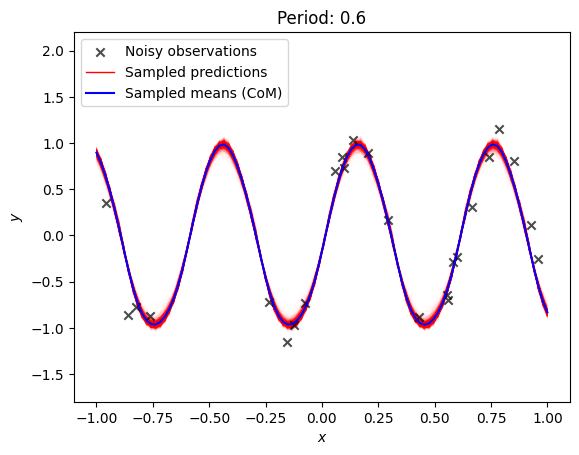

/Users/keisukeonoue/ws/TPBO_jax/notebooks/../src/tp.py:97: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:04<00:00, 833.71it/s, 15 steps of size 1.33e-01. acc. prob=0.96] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        df      8.22      9.56      4.94      0.03     19.85    954.61      1.00
  k_length      0.40      0.29      0.34      0.01      0.79   1291.60      1.00
   k_scale      0.48      0.44      0.36      0.05      0.94   1152.75      1.00
     noise      1.26      1.18      0.96      0.25      2.45    908.18      1.00
    period      1.00      0.00      1.00      1.00      1.00       nan       nan
         r      0.22      0.36      0.11      0.01      0.46    642.46      1.00



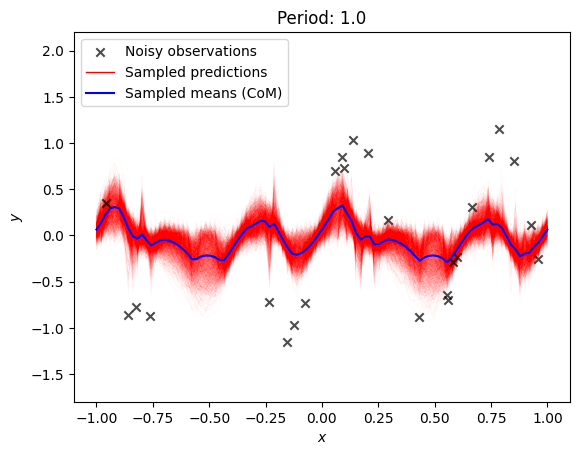

/Users/keisukeonoue/ws/TPBO_jax/notebooks/../src/tp.py:97: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:07<00:00, 559.48it/s, 15 steps of size 1.55e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        df      2.94      5.08      1.02      0.02      7.69    899.14      1.00
  k_length      0.76      0.18      0.74      0.49      1.06   1038.09      1.00
   k_scale      4.25      3.98      3.05      0.29      8.77    787.81      1.00
     noise      0.10      0.10      0.08      0.01      0.22    758.50      1.01
    period      1.24      0.01      1.24      1.22      1.27   1029.00      1.00
         r      0.30      0.46      0.17      0.02      0.57   1040.09      1.00



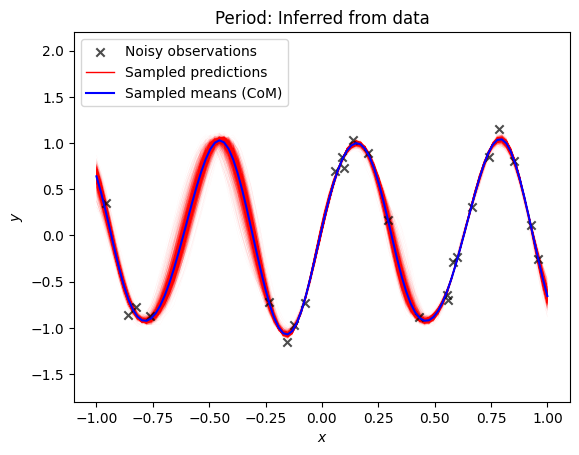

In [14]:
for p in [0.3, 0.6, 1.0, None]:
    # Get a kernel prior function and initialize the model
    k_prior = get_kernel_prior(p)
    tp_model = StudentTProcess(1, kernel='Periodic', kernel_prior=k_prior)
    # Run HMC to obtain posterior samples
    tp_model.fit(rng_key, X, y, num_chains=1)
    # Get GP prediction
    y_pred, y_sampled = tp_model.predict(rng_key_predict, X_test, n=200)

    # Plot results
    _, ax = plt.subplots(dpi=100)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.scatter(X, y, marker='x', c='k', zorder=1, label="Noisy observations", alpha=0.7)
    for y1 in y_sampled:
        ax.plot(X_test, y1.mean(0), lw=.1, zorder=0, c='r', alpha=.1)
    l, = ax.plot(X_test, y_sampled[0].mean(0), lw=1, c='r', alpha=1, label="Sampled predictions")
    ax.plot(X_test, y_pred, lw=1.5, zorder=1, c='b', label='Sampled means (CoM)')
    ax.legend(loc='upper left')
    l.set_alpha(0)
    ax.set_ylim(-1.8, 2.2)
    ax.set_title("Period: {}".format(p if p else "Inferred from data"))
    plt.show()

One can see that we get a more reliable result when the period value is inferred from data. In all the cases, the uncertainty (dispersion in sampled prediction) informs us about how much we can trust results.

In [17]:
x = np.array([
    [[1, 2, 3, 4], [3, 4, 5, 6]],
    [[5, 6, 7, 8], [7, 8, 9, 10]],
    [[9, 10, 11, 12], [11, 12, 13, 14]]
])

x

array([[[ 1,  2,  3,  4],
        [ 3,  4,  5,  6]],

       [[ 5,  6,  7,  8],
        [ 7,  8,  9, 10]],

       [[ 9, 10, 11, 12],
        [11, 12, 13, 14]]])

In [18]:
x.shape

(3, 2, 4)

In [21]:
x.std(axis=0)

array([[3.26598632, 3.26598632, 3.26598632, 3.26598632],
       [3.26598632, 3.26598632, 3.26598632, 3.26598632]])

In [22]:
x.std(axis=1)

array([[1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]])

In [23]:
x.std(axis=2)

array([[1.11803399, 1.11803399],
       [1.11803399, 1.11803399],
       [1.11803399, 1.11803399]])

In [24]:
x.std(axis=(0,1))

array([3.41565026, 3.41565026, 3.41565026, 3.41565026])